# 라이브러리

In [1]:
# 데이터 불러오기
import psycopg2
import json

# 데이터 전처리
import pandas as pd
import numpy as np
import re
import datetime

# 데이터 시각화
import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib import font_manager, rc
import platform

if platform.system() == 'Windows':
    font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
    rc('font', family=font_name)
else:    
    rc('font', family='AppleGothic')

# 기타
import warnings
warnings.filterwarnings("ignore")

# 데이터 불러오기

In [6]:
def call_df(table_name):
    with open('config.json', 'r') as f:
        config = json.load(f)
        
    conn = psycopg2.connect(user = config['USER'],
                              password = config['PASSWORD'],
                              host = config['HOST'],
                              port = config['PORT'],
                              database = config['DATABASE'])
    
    sql = f'SELECT * FROM {table_name}'
    df = pd.read_sql_query(sql, conn)
    conn.close()
    return df

In [12]:
price = call_df('crawling_db.price_table')
clustered = pd.read_pickle('./data/clustered_apartment.pkl')
df = price.merge(clustered, how='left', on='apartment_id')

# 데이터 전처리

In [4]:
# area => 숫자가 아닌 무언가가 처음 나오는 것 기준으로 앞의 내용
df['area'] = df['area'].apply(lambda x: int(re.split('\D',x)[0]))
df['period'] = pd.to_datetime(df['period'], format='%Y.%m')

# 사용자 환경 설정

In [5]:
user_option = {
    'apartment_name':'당산반도유보라팰리스', # 검색하고 싶은 아파트의 이름
    'apartment_area':108, # 그 아파트의 면적
}

In [6]:
# 클러스터 찾기
group_name = clustered.loc[clustered['apartment_name'] == user_option['apartment_name'],'cluster'].values[0]
print(f"{user_option['apartment_name']} 아파트의 그룹은 {group_name}입니다.")

당산반도유보라팰리스 아파트의 그룹은 8입니다.


# 아파트 찾기

In [7]:
# 면적이 +- 3인 아파트 찾기
temp = df[(df['cluster'] == group_name) &
          (df['area'] <= user_option['apartment_area']+3) &
          (df['area'] >= user_option['apartment_area']-3)]

if len(temp)==0:
    print('해당 면적 범위의 아파트는 존재하지 않습니다.')

In [8]:
def Q1(x): 
    return np.percentile(x, 0.25)
def Q2(x): 
    return np.percentile(x, 0.5)
def Q3(x): 
    return np.percentile(x, 0.75)

In [9]:
# 날짜의 범위
standard = temp.loc[temp['apartment_name'] == user_option['apartment_name'],'period']
if len(standard)!=0: # 만약 해당 면적의 아파트의 거래 기록이 있다면
    date_range = pd.date_range(start = standard.min(), # 가장 빠른 월
                           end = temp['period'].max(), # 가장 늦은 월
                           freq='MS')
else: # 없다면
    print('해당 면적 범위의 아파트는 존재하지 않습니다.')

# 기존 데이터를 최대한 활용하기
exist = (temp.loc[temp['apartment_name'] == user_option['apartment_name']].
         groupby('period')['amount'].
         agg([Q1,Q2,Q3],).
         reset_index())

# 비어있는 날짜
empty_date = date_range[~date_range.isin(exist['period'])]

# 빈 곳을 채워넣을 데이터
supply = (temp.groupby('period')['amount'].
          agg([Q1,Q2,Q3]).
          reset_index())

# 병합 후 재정렬
total = (pd.concat([exist,
                    supply.loc[supply['period'].isin(empty_date)]],
                   axis = 0).
         sort_values('period').
         set_index(keys='period')/10000000) # 천만원 단위

# VAR 모델링

## 평가
- 가지고 있는 데이터의 마지막 4개월을 제외한 이전 시점의 데이터로 학습하여, 마지막 4개월치와 비교하겠습니다.

In [10]:
train = total[:-4]
test = total[-4:]

In [11]:
from statsmodels.tsa.vector_ar.var_model import VAR
model = VAR(train)
model_fit = model.fit()

In [12]:
yhat = model_fit.forecast(y = train.values, steps=4)
var = pd.DataFrame(yhat,
                   columns=['Q1_hat','Q2_hat','Q3_hat'],
                   index=test.index)

                   Q1        Q2         Q3     Q1_hat     Q2_hat     Q3_hat
period                                                                     
2020-01-01  118.50000  118.5000  118.50000  62.660019  63.165478  63.526307
2020-02-01   33.37900   35.7580   37.61550  50.035403  50.596816  50.980060
2020-03-01   38.46725   40.1345   41.80175  46.736980  47.321332  47.713097
2020-04-01   40.42275   40.8455   41.26825  45.910523  46.500572  46.893793


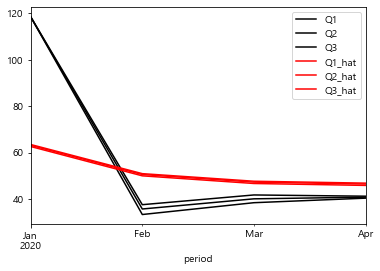

In [13]:
result = pd.concat([test,var],axis=1)
print(result)
result.plot(kind='line',
            color=['black','black','black','red','red','red'])
plt.show()

## 실제 활용

In [14]:
from statsmodels.tsa.vector_ar.var_model import VAR

n = 4 # 몇 달 앞까지 볼 것인가
new_index = pd.date_range(start = total.index[-1], periods = n+1, freq='MS')[1:] # 예측할 월의 리스트

model = VAR(total)
model_fit = model.fit()
pred = model_fit.forecast(y = total.values, steps=n)
pred = pd.DataFrame(pred,
                    columns=['Q1','Q2','Q3'],
                    index=new_index)
result = pd.concat([total,pred],axis=0)

                   Q1         Q2         Q3
2020-05-01  43.260771  43.857799  44.281288
2020-06-01  44.953627  45.560704  45.973423
2020-07-01  45.532723  46.142275  46.554834
2020-08-01  45.720177  46.330081  46.743036


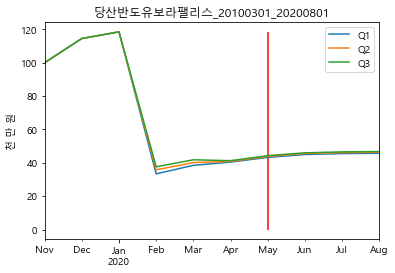

In [15]:
print(result.loc[new_index])
result[-(n+6):].plot(kind='line') # 결과물은 이전과 비교하기 위해 6개월 전부터 시각화
plt.title(f"{user_option['apartment_name']}_{result.index[0].strftime('%Y%m%d')}_{result.index[-1].strftime('%Y%m%d')}")
plt.vlines(x=pred.index[0], ymin=0, ymax=result.max(), color='red')
plt.ylabel('천 만 원')
plt.savefig(f"./output/{user_option['apartment_name']}_{result.index[0].strftime('%Y%m%d')}_{result.index[-1].strftime('%Y%m%d')}.png",
           dpi=300)
plt.show()